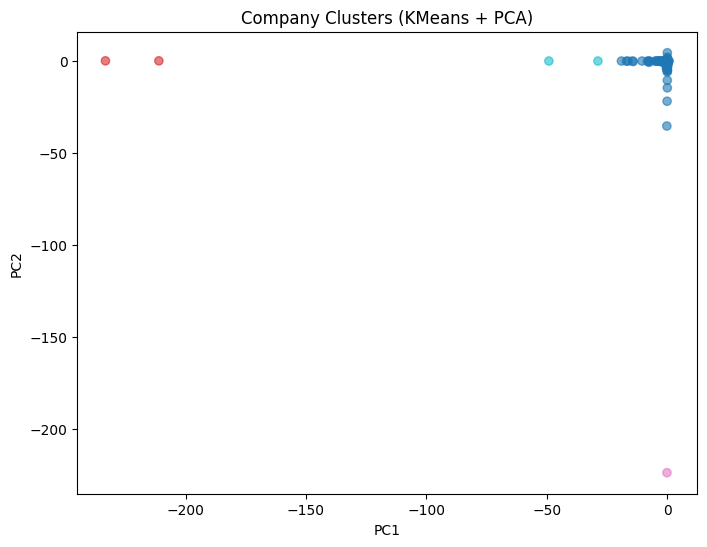

Class distribution in full data:
Label
1    26222
0    26218
Name: count, dtype: int64

Training set:
Label
0    20996
1    20956
Name: count, dtype: int64

Test set:
Label
1    5266
0    5222
Name: count, dtype: int64


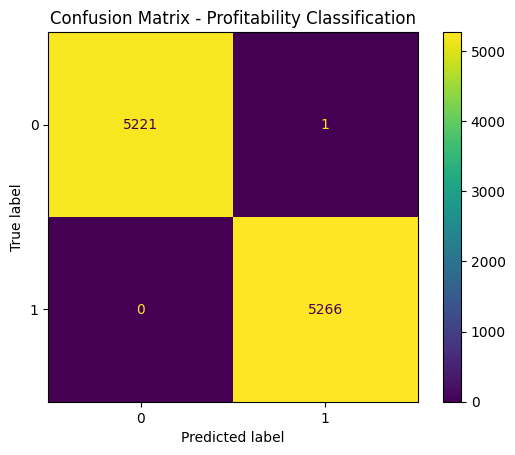


Accuracy (دقت): 0.9999

Classification Report (گزارش طبقه‌بندی):
                          precision    recall  f1-score   support

Class 0 (Non-profitable)       1.00      1.00      1.00      5222
    Class 1 (Profitable)       1.00      1.00      1.00      5266

                accuracy                           1.00     10488
               macro avg       1.00      1.00      1.00     10488
            weighted avg       1.00      1.00      1.00     10488



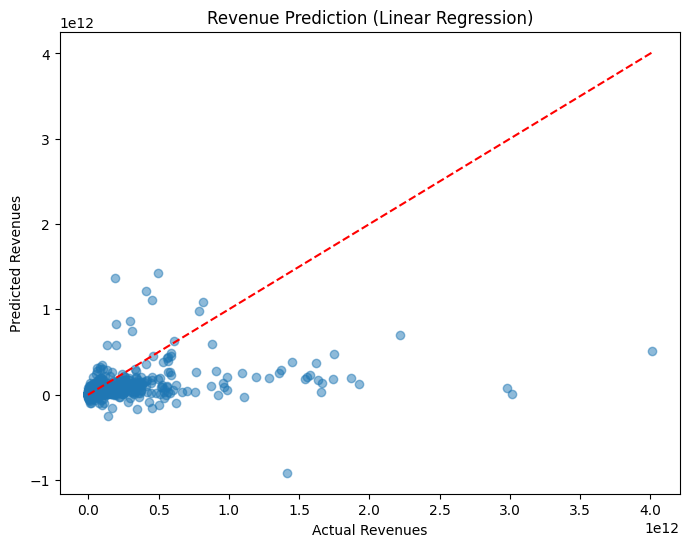

Mean Squared Error for Revenue Prediction: 8.079331579711782e+21


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, classification_report,
    mean_squared_error
)
from sklearn.model_selection import train_test_split

# -------------------------------
# Load dataset from GitHub
# -------------------------------
url = "https://raw.githubusercontent.com/AZFARHAD24511/datasets/main/financial_dataset.csv"
final_df = pd.read_csv(url)

# Optional: create output folder if not exists
figures_dir = "figures"
os.makedirs(figures_dir, exist_ok=True)

features = final_df[["ProfitMargin", "DebtRatio", "ROA"]].copy()
features = features[np.isfinite(features).all(1)]  # Remove NaN and inf

scaled = StandardScaler().fit_transform(features)
pca = PCA(n_components=2)
components = pca.fit_transform(scaled)

kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit_predict(components)

plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], c=labels, cmap='tab10', alpha=0.6)
plt.title("Company Clusters (KMeans + PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig(os.path.join(figures_dir, "clusters.png"))
plt.show()

# -------------------------------
# Classification: RandomForest
# -------------------------------
clf_features = final_df[["ProfitMargin", "DebtRatio", "ROA"]].copy()
clf_labels = final_df["Label"]

# Remove NaN, inf and match indices
mask = np.isfinite(clf_features).all(axis=1)
clf_features = clf_features[mask]
clf_labels = clf_labels[mask]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    clf_features, clf_labels, test_size=0.2, random_state=42
)

# Print class distribution
print("Class distribution in full data:")
print(clf_labels.value_counts())
print("\nTraining set:")
print(y_train.value_counts())
print("\nTest set:")
print(y_test.value_counts())

# Train classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Profitability Classification")
plt.savefig(os.path.join(figures_dir, "confusion_matrix.png"))
plt.show()

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy (دقت): {accuracy:.4f}")

# Classification report (Precision, Recall, F1)
report = classification_report(y_test, y_pred, target_names=["Class 0 (Non-profitable)", "Class 1 (Profitable)"])
print("\nClassification Report (گزارش طبقه‌بندی):")
print(report)

# -------------------------------
# Regression: Revenue Prediction
# -------------------------------
reg_features = final_df[["Assets", "Liabilities", "NetIncomeLoss"]]
reg_target = final_df["Revenues"]

# Remove invalid rows
reg_mask = np.isfinite(reg_features).all(axis=1) & np.isfinite(reg_target)
reg_features = reg_features[reg_mask]
reg_target = reg_target[reg_mask]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(reg_features, reg_target, test_size=0.2, random_state=42)

reg = LinearRegression()
reg.fit(X_train_r, y_train_r)
y_pred_r = reg.predict(X_test_r)

plt.figure(figsize=(8, 6))
plt.scatter(y_test_r, y_pred_r, alpha=0.5)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--')
plt.xlabel("Actual Revenues")
plt.ylabel("Predicted Revenues")
plt.title("Revenue Prediction (Linear Regression)")
plt.savefig(os.path.join(figures_dir, "revenue_prediction.png"))
plt.show()

mse = mean_squared_error(y_test_r, y_pred_r)
print("Mean Squared Error for Revenue Prediction:", mse)
